In [1]:
#Y1 Data

import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio

%matplotlib inline

%load_ext autoreload
%autoreload 2

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS import priorCut_test

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# calling map 
path = '/fs/scratch/PCON0003/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')

#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask
LSSMask = LSSMask[LSSMask['DEC']>-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [3]:
#read in gold catalogs here:
##ST82 REGION catalog:

train_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/'
path =  train_path
train_keyword = 'Y1A1_GOLD_STRIPE82_v2'
    
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'EBV']

gold_st82 = io.SearchAndCallFits(path = train_path, columns = columns, keyword = train_keyword )
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]
    
def RemovingSLRReddening(cat):


    if 'SLR_SHIFT_G' not in cat.dtype.names : 
        import numpy.lib.recfunctions as rf   
        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        from y1a1_slr_shiftmap import SLRShift
        zpfile = '/fs/scratch/PCON0003/warner785/bwarner/y1a1_wide_slr_wavg_zpshift2.fit'
        slrshift = SLRShift(zpfile, fill_periphery=True)
        offsets_g = slrshift.get_zeropoint_offset('g',cat['RA'],cat['DEC'],interpolate=True)
        offsets_r = slrshift.get_zeropoint_offset('r',cat['RA'],cat['DEC'],interpolate=True)
        offsets_i = slrshift.get_zeropoint_offset('i',cat['RA'],cat['DEC'],interpolate=True)
        offsets_z = slrshift.get_zeropoint_offset('z',cat['RA'],cat['DEC'],interpolate=True)

        offsets = [ offsets_g, offsets_r, offsets_i, offsets_z  ]
        from pandas import DataFrame, concat
        nametag = ['SLR_SHIFT_'+f for f in ['G', 'R', 'I', 'Z'] ]
        catnametag = cat.dtype.names
        try : 
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat, index = catnametag)
            #del cat['index']
            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
        
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping")
            
            #offsetsdf = np.array(offsetsdf).byteswap().newbyteorder()
            cat = np.array(cat).byteswap().newbyteorder()
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat)

            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
            cat.dtype.names = [str(x) for x in cat.dtype.names]
            
            #matched = pd.merge(desData, goldData, on=key, how=how, suffixes = suffixes, left_index=left_index)


    print('Removing SLR Shift ')
    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  removing SLR from ', mag)
        for b in ['G', 'R', 'I', 'Z']:
            cat[mag + '_'+b] = cat[mag + '_'+b] - cat['SLR_SHIFT'+ '_'+b]

    """
    cat = rf.append_fields(cat, 'SLR_SHIFT_G', offsets_g)
    cat = rf.append_fields(cat, 'SLR_SHIFT_R', offsets_r)
    cat = rf.append_fields(cat, 'SLR_SHIFT_I', offsets_i)
    cat = rf.append_fields(cat, 'SLR_SHIFT_Z', offsets_z)
    """
    return cat

def AddingSFD98Reddening(cat, kind='SPT', coeff = [3.186,2.140,1.569,1.196 ] ):
    import numpy.lib.recfunctions as rf
    import pandas as pd

    band = ['G', 'R', 'I', 'Z']

    if 'EBV' not in cat.dtype.names :   
     
        print('Using SFD98 nside 4096 healpix map')
        print('Bands :',  band)
        #print 'NSIDE = 4096'
        print('coefficients = ', coeff)
        nside = 4096

        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        #sfdfile = '/n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit'
        mapname = '/fs/scratch/PCON0003/warner785/bwarner/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
        #mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
        reddening_ring = hp.read_map(mapname)
        hpIndices = np.arange(reddening_ring.size)
        #goodmask = hp.mask_good(reddening_ring)
        #goldmask = 

        goodIndices = hpIndices #hpIndices[goodmask]
        clean_map = reddening_ring #reddening_ring[goodmask]

        sysMap = np.zeros((clean_map.size, ), dtype=[('PIXEL', 'i4'), ('EBV', 'f8'), ('RA', 'f8'), ('DEC', 'f8')])
        sysMap['PIXEL'] = goodIndices
        sysMap['EBV'] = clean_map
        
        sys_ra, sys_dec = hpHEALPixelToRaDec(goodIndices, nside = nside)
        sysMap['RA'] = sys_ra
        sysMap['DEC'] = sys_dec

        from cmass_modules.Cuts import keepGoodRegion
        sysMap = keepGoodRegion(sysMap)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]


        cat_hp = cat
        hpind = hpRaDecToHEALPixel(cat_hp['RA'], cat_hp['DEC'], nside= 4096, nest= False)
        #cat_hp.dtype.names = [str(x) for x in cat_hp.dtype.names]
        cat_hp = changeColumnName(cat_hp, name = 'HPIX', rename = 'PIXEL')
        cat_hp['PIXEL'] = hpind
        
        #sfdmap = changeColumnName( sysMap_ge, name = 'SIGNAL', rename = 'SFD98' )


        try : 

            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping ....")

            cat_hp = np.array(cat_hp).byteswap().newbyteorder()
            #sfdmap = np.array(sfdmap).byteswap().newbyteorder()
            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            

            #print cat_Data.keys()
            #print sfdData.keys()
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
            
        matched_arr = matched.to_records(index=False)
        matched_arr.dtype.names = [str(x) for x in matched_arr.dtype.names]


    else : matched_arr = cat

    print('Adding SFD98 Shift ')
    print('Bands :',  band)
    print('coefficients = ', coeff)

    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  Adding SFD to ', mag)
        for i,b in enumerate(band):
            matched_arr[mag + '_'+b] = matched_arr[mag + '_'+b] - matched_arr['EBV'] * coeff[i]    

    return matched_arr

params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_st82 = RemovingSLRReddening(gold_st82)
        gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]
print(gold_st82.size)


Calling catalogs >>>
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 1/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 2/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 3/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 4/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 5/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 6/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 7/8 /fs/scratch/PCON0003/warner785/bwarner/gold_ca

In [4]:
#implement Cuts.keepgoodregion:

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = LSSGoldmask['PIXEL']
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des
    
gold_st82 = keepGoodRegion(gold_st82)
#print(gold_st82.size)

#gold_spt = keepGoodRegion(gold_spt)
#print(gold_spt.size)

In [5]:
#cmass catalog

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

#matching:
# find cmass in des_gold side --------------------

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]

print(nocmass.size)

print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 13046
681836
('num of cmass in des side', 12639, '(5%)')


In [6]:
cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size

print(cmass_fraction)

0.01819935922819396


In [7]:
healConfig={'out_nside':64, 'nest':True}

In [8]:
train_sample = HealPixifyCatalogs(catalog=train_sample, healConfig=healConfig, ratag='RA', dectag = 'DEC')
gold_st82 = HealPixifyCatalogs(catalog=gold_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')

evenmask_train = train_sample['HEALIndex']%2 == 0
evenmask = gold_st82['HEALIndex']%2 == 0

print('odd', np.sum(evenmask_train), ' even', np.sum(~evenmask_train))

GoldMask_st82_hpix64 = HealPixifyCatalogs(catalog=GoldMask_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')
evenmask_map = GoldMask_st82_hpix64['HEALIndex']%2 == 0

#pixarea64 = hp.nside2pixarea( 64, degrees = True)

print('odd', np.sum(evenmask_map), ' even', np.sum(~evenmask_map))
print('area', 'odd', np.sum(evenmask_map)*pixarea, ' even', np.sum(~evenmask_map)*pixarea)

GoldMask_st82_hpix64.size

train_even = train_sample[evenmask_train]
train_odd = train_sample[~evenmask_train]
gold_st82_even = gold_st82[evenmask]
gold_st82_odd = gold_st82[~evenmask]  # Validation Region is using Odd Healpix

odd 6547  even 6499
odd 304376  even 305127
area odd 62.36836976435403  even 62.522253926354416


In [9]:
# ODD cmass fraction: use even as validation

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_even['RA'], \
                                         gold_st82_even['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82_even.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des_even, nocmass_even = gold_st82_even[cmass_mask], gold_st82_even[~cmass_mask]

print(nocmass_even.size)

print(('num of cmass in des side in training', clean_cmass_data_des_even.size, '({:0.0f}%)'.format(clean_cmass_data_des_even.size*1./cmass.size*100.)))

340202
('num of cmass in des side in training', 6325, '(2%)')


In [10]:
# EVEN cmass fraction: use odd as validation

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_odd['RA'], \
                                         gold_st82_odd['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82_odd.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des_odd, nocmass_odd = gold_st82_odd[cmass_mask], gold_st82_odd[~cmass_mask]

print(nocmass_odd.size)

print(('num of cmass in des side in training', clean_cmass_data_des_odd.size, '({:0.0f}%)'.format(clean_cmass_data_des_odd.size*1./cmass.size*100.)))

341634
('num of cmass in des side in training', 6314, '(2%)')


In [11]:
cmass_fraction_even = clean_cmass_data_des_even.size *1./gold_st82_even.size
cmass_fraction_odd = clean_cmass_data_des_odd.size *1./gold_st82_odd.size

print(cmass_fraction_even)
print(cmass_fraction_odd)

0.018252545977658307
0.01814638969041351


In [12]:
#Running my pickle file
import pickle

# pickle file: changing from 'b'
outdir = '../output/test/fitting/'
dmass_pickle = outdir+'gauss_cmass_v6.pkl'  # cmass
dmass_no_pickle = outdir+'gauss_no_v6.pkl' # noncmass
#clf_cmass_su = XD_fitting_X( None, None, pickleFileName = cmass_su_pickle)

f = open(dmass_pickle, 'rb')
g = open(dmass_no_pickle, 'rb')

clf_dmass = pickle.load(f, encoding="latin1")
clf_dmass = clf_dmass['retval']
clf_nodmass = pickle.load(g, encoding="latin1")
clf_nodmass = clf_nodmass['retval']
X_sample_dmass = clf_dmass.sample(200000)        # non-cmass model
X_sample_nodmass = clf_nodmass.sample(200000)
print(clf_dmass)
print(clf_nodmass)

In [13]:
#Running Su's pickle file
import pickle

# Su's pickle file: changing from 'b'
outdir = '../code/output/n2/'
cmass_su_pickle = outdir+'gold_st82_XD_cmass_full_tol1e5.pkl'  # cmass Su
cmass_su_no_pickle = outdir+'gold_st82_XD_no_full_tol1e5.pkl' # noncmass Su
#clf_cmass_su = XD_fitting_X( None, None, pickleFileName = cmass_su_pickle)

f = open(cmass_su_pickle, 'rb')
g = open(cmass_su_no_pickle, 'rb')

clf_cmass_su = pickle.load(f, encoding="latin1")
clf_cmass_su = clf_cmass_su['retval']
clf_nocmass_su = pickle.load(g, encoding="latin1")
clf_nocmass_su = clf_nocmass_su['retval']
X_sample_cmass_su = clf_cmass_su.sample(200000)        # non-cmass model
X_sample_nocmass_su = clf_nocmass_su.sample(200000)
print(clf_cmass_su)
print(clf_nocmass_su)

In [25]:
# New method, my EVEN pickle file:
import pickle
# pickle file: changing from 'b'
outdir = '../output/validate_NEST/'
dmass_pickle_even = outdir+'gold_st82_XD_cmass_NEST_even_new.pkl'  # cmass
dmass_no_pickle_even = outdir+'gold_st82_XD_no_NEST_even_20.pkl' # noncmass
#clf_cmass_su = XD_fitting_X( None, None, pickleFileName = cmass_su_pickle)

f = open(dmass_pickle_even, 'rb')
g = open(dmass_no_pickle_even, 'rb')

clf_dmass_even = pickle.load(f, encoding="latin1")
clf_dmass_even = clf_dmass_even['retval']
clf_nodmass_even = pickle.load(g, encoding="latin1")
clf_nodmass_even = clf_nodmass_even['retval']
X_sample_dmass_even = clf_dmass_even.sample(200000)        # non-cmass model
X_sample_nodmass_even = clf_nodmass_even.sample(200000)
print(clf_dmass_even)
print(clf_nodmass_even)

In [12]:
#Bovy method:
#EVEN file:
import pickle
# pickle file: changing from 'b'
outdir = '../output/test/fitting/'
dmass_pickle_even = outdir+'gauss_gold_bovy.xdgmm'  # cmass
dmass_no_pickle_even = outdir+'gauss_nogold_bovy.xdgmm' # noncmass
#clf_cmass_su = XD_fitting_X( None, None, pickleFileName = cmass_su_pickle)

f = open(dmass_pickle_even, 'rb')
g = open(dmass_no_pickle_even, 'rb')

clf_dmass_even = pickle.load(f, encoding="latin1")
clf_dmass_even = clf_dmass_even['retval']
clf_nodmass_even = pickle.load(g, encoding="latin1")
clf_nodmass_even = clf_nodmass_even['retval']
X_sample_dmass_even = clf_dmass_even.sample(200000)        # non-cmass model
X_sample_nodmass_even = clf_nodmass_even.sample(200000)
print(clf_dmass_even)
print(clf_nodmass_even)

FileNotFoundError: [Errno 2] No such file or directory: '../output/test/fitting/gauss_gold_bovy.xdgmm'

In [15]:
# New method, my ODD pickle file:

# pickle file: changing from 'b'
outdir = '../output/validate_NEST/'
dmass_pickle_odd = outdir+'gold_st82_XD_cmass_NEST_odd2.pkl'  # cmass
dmass_no_pickle_odd = outdir+'gold_st82_XD_no_NEST_odd2.pkl' # noncmass
#clf_cmass_su = XD_fitting_X( None, None, pickleFileName = cmass_su_pickle)

f = open(dmass_pickle_odd, 'rb')
g = open(dmass_no_pickle_odd, 'rb')

clf_dmass_odd = pickle.load(f, encoding="latin1")
clf_dmass_odd = clf_dmass_odd['retval']
clf_nodmass_odd = pickle.load(g, encoding="latin1")
clf_nodmass_odd = clf_nodmass_odd['retval']
X_sample_dmass_odd = clf_dmass_odd.sample(200000)        # non-cmass model
X_sample_nodmass_odd = clf_nodmass_odd.sample(200000)
print(clf_dmass_odd)
print(clf_nodmass_odd)

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pcenter 20
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00185098 0.0647535  0.12593467 0.1722365  0.22279349 0.26809955
 0.34794908 0.37859425 0.41899441 0.51265823 0.50669643 0.55112219
 0.63549161 0.66753247 0.6875     0.77458034 0.78772379 0.85260771
 0.88645418 0.92363112]
frac.size 20
frac err 20
[0.04048882 0.05330018 0.0559017  0.06108472 0.06201737 0.06495698
 0.06375767 0.06495698 0.06666667 0.06415003 0.06637233 0.06726728
 0.06142951 0.06237829 0.06286946 0.05564149 0.05698029 0.05157106
 0.04740455 0.03949763]


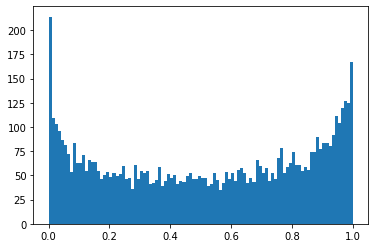

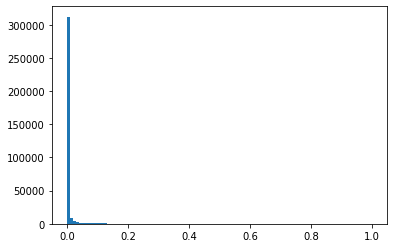

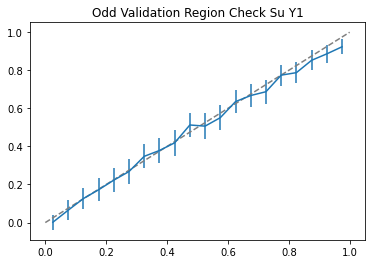

In [15]:
# Figure 3 start: Su:
%matplotlib inline
import matplotlib.pyplot as plt

cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs
# Assigning CMASS probabilities to Gold Y1 in Stripe 82.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

clean_dmass_prob = assignCMASSProb(clean_cmass_data_des_odd, clf_cmass_su, clf_nocmass_su, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

dmass_st82_real = clean_dmass_prob

dmass_st82_val = assignCMASSProb(gold_st82_odd, clf_cmass_su, clf_nocmass_su, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
print('pcenter',pcenter.size)
N, _ = np.histogram(dmass_st82_real['CMASS_PROB'], bins=pbin) # -- true cmass
print('pbin =', pbin)
M, _ = np.histogram(dmass_st82_val['CMASS_PROB'], bins=pbin) # -- dmass

fig, ax = plt.subplots()
ax.hist( dmass_st82_real['CMASS_PROB'], bins= 100)
fig, ax = plt.subplots()
ax.hist( dmass_st82_val['CMASS_PROB'], bins= 100)

#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/M
print('frac = ', frac)
print('frac.size', frac.size)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
print('frac err', fracerr.size)
fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
plt.title('Odd Validation Region Check Su Y1')
print(fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo_y1_su.pdf')

random sampling... 
num of randomly sampled cmass  6325
num of randomly sampled non-cmass  34020
cmass_fraction (cmass/non-cmass):  0.018252545977658307
Using central 100% to set range.
Using central 100% to set range.


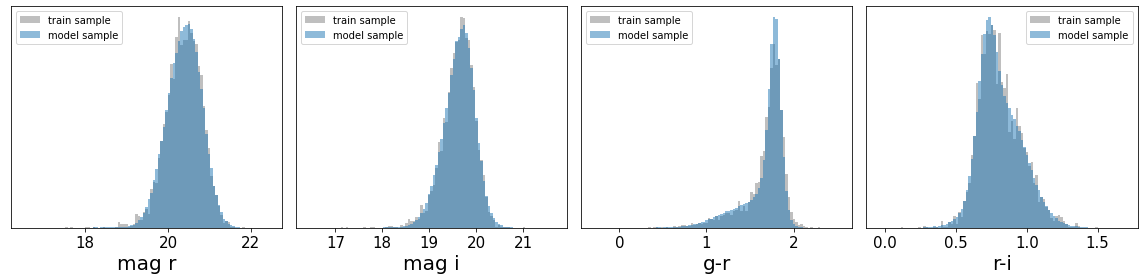

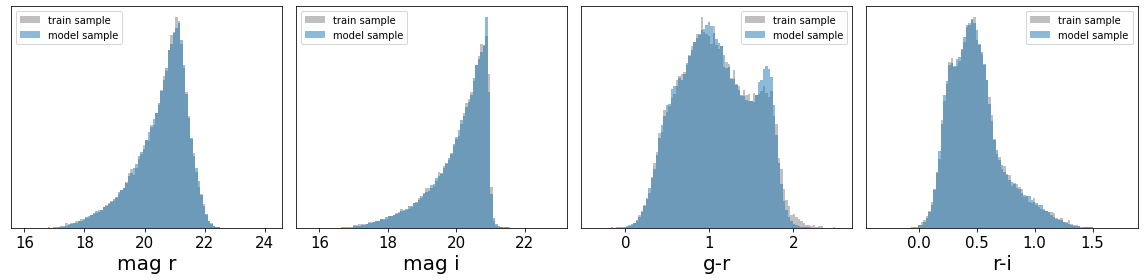

In [16]:
# do ks-test
# make 2D plots: contour plots

n_sample =  int(clean_cmass_data_des_even.size)  # train cmass sample size
n_sample_non = int(nocmass_even.size/10)  # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_cmass_data_des_even.size), size = n_sample)
clean_cmass_data_des_sub = clean_cmass_data_des_even[sampling_ind]
print('num of randomly sampled cmass ', clean_cmass_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(nocmass_even.size), size = n_sample_non )
nocmass_sub = nocmass_even[random_sampling_ind]
print('num of randomly sampled non-cmass ', nocmass_sub.size)

# The fraction of CMASS galaxies in the training region.
# This number is required to put a prior for the Bayesian statistics 
cmass_fraction = clean_cmass_data_des_even.size *1./gold_st82_even.size
print('cmass_fraction (cmass/non-cmass): ', cmass_fraction)
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'cmassfrac', 'w')
f.write('{0:.10f}'.format(cmass_fraction))
f.close()

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_cmass = None    # for cmass
n_no = None       # for non-cmass 

# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )


doVisualization_1d( data=[X_cmass_true, X_sample_cmass_su], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

doVisualization_1d( data=[X_no_true, X_sample_nocmass_su], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

In [32]:
# prob bin center, fraction,  err

print('pcenter: ', pcenter)
print('fraction: ', frac)
print('error: ', fracerr)

pcenter:  [0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975]
fraction:  [0.00185098 0.0647535  0.12593467 0.1722365  0.22279349 0.26809955
 0.34794908 0.37859425 0.41899441 0.51265823 0.50669643 0.55112219
 0.63549161 0.66753247 0.6875     0.77458034 0.78772379 0.85260771
 0.88645418 0.92363112]
error:  [0.04048882 0.05330018 0.0559017  0.06108472 0.06201737 0.06495698
 0.06375767 0.06495698 0.06666667 0.06415003 0.06637233 0.06726728
 0.06142951 0.06237829 0.06286946 0.05564149 0.05698029 0.05157106
 0.04740455 0.03949763]


In [34]:
su_pcenter= [] 
su_frac= []
su_err= []

for x in range(len(pcenter)):   #    print(pcenter[x]*100,frac[x]*100,fracerr[x]*100) 
    su_pcenter.append(pcenter[x]*100)
    su_frac.append(frac[x]*100)
    su_err.append(fracerr[x]*100)
print(su_err)    

#what causes the differences? --- small differences, but same data
#sample difference-- using all of st82

#Su's split for training and validation--- github *** jupyter notebook-- Splitting ----- not full st82** --- just validation set
# https://github.com/sujeong-lee/DMASS/blob/py3/notebook/XD_fitting-new%20DMASS-half%20st82.ipynb
# split st82 region in half for fig 3
# module applied to spt: trained over all st82

#noise component to XDfitting-- can't control noise level

#if splitting does not nulify the difference: use pickle file to see if the same result is attainable-- if not: 
#problem within XDfitting

#for toy distributions (some part of pickle file): fluctuations between runs ** what are the fluc.

[4.04888165089458, 5.330017908890261, 5.5901699437494745, 6.108472217815261, 6.201736729460423, 6.495698024616309, 6.375767130633382, 6.495698024616309, 6.666666666666667, 6.415002990995841, 6.63723311599972, 6.726727939963125, 6.142951168339512, 6.237828615518053, 6.286946134619314, 5.564148840746572, 5.698028822981898, 5.157106231293967, 4.740454631399772, 3.949762527666821]


[-0.10526662  0.0460154  -0.07699148  0.04610233  0.04826327 -0.08069503
  0.          0.          0.06006127 -0.12805686  0.18271028 -0.03023264
  0.13160688 -0.05980798 -0.1089255   0.1154695   0.05632455  0.05575412
 -0.01589872  0.02802389]
[ 0.00977281  0.07395958  0.66197202  0.00872559  0.65971934  1.4458592
  0.54991952  0.06057508  0.11576778  2.33587213  0.27822444  0.36041736
 -0.67787354 -0.75828454  3.03082192 -0.15130041  0.28521311  0.12205965
  0.06745296  0.03454843]


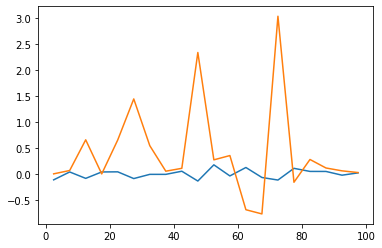

In [60]:
# Su's numbers:

su_data_string = '''2.500000000000000000e+00 1.948703339465334139e-01 3.943615033625495148e+00
7.500000000000000888e+00 6.549309104675374194e+00 5.376033305704703835e+00
1.250000000000000000e+01 1.325543916196615690e+01 5.513178464199712359e+00
1.750000000000000000e+01 1.723237597911227326e+01 6.154574548966635916e+00
2.250000000000000000e+01 2.293906810035842270e+01 6.250000000000000000e+00
2.750000000000000355e+01 2.825581395348837432e+01 6.415002990995841259e+00
3.250000000000000711e+01 3.534482758620689680e+01 6.375767130633382074e+00
3.750000000000000711e+01 3.792000000000000171e+01 6.495698024616308963e+00
4.250000000000000711e+01 4.201520912547528042e+01 6.726727939963124570e+00
4.750000000000000000e+01 5.360169491525424235e+01 6.286946134619314286e+00
5.250000000000000000e+01 5.094786729857819552e+01 6.819943394704734985e+00
5.750000000000000711e+01 5.547263681592039575e+01 6.696495301824251456e+00
6.250000000000001421e+01 6.287128712871287206e+01 6.274558051381585955e+00
6.750000000000000000e+01 6.599496221662468542e+01 6.178020632152154690e+00
7.250000000000001421e+01 7.178082191780822541e+01 6.178020632152154690e+00
7.750000000000000000e+01 7.730673316708229947e+01 5.679618342470647896e+00
8.250000000000000000e+01 7.905759162303664311e+01 5.754353376484360183e+00
8.750000000000001421e+01 8.538283062645011512e+01 5.212860351426868988e+00
9.250000000000000000e+01 8.871287128712872061e+01 4.724555912615340247e+00
9.750000000000001421e+01 9.239766081871344738e+01 3.977786420878649754e+00'''

#su_numbers = np.array('2.500000000000000000e+00 1.948703339465334139e-01 3.943615033625495148e+00 7.500000000000000888e+00 6.549309104675374194e+00 5.376033305704703835e+00 1.250000000000000000e+01 1.325543916196615690e+01 5.513178464199712359e+00 1.750000000000000000e+01 1.723237597911227326e+01 6.154574548966635916e+00 2.250000000000000000e+01 2.293906810035842270e+01 6.250000000000000000e+00 2.750000000000000355e+01 2.825581395348837432e+01 6.415002990995841259e+00 3.250000000000000711e+01 3.534482758620689680e+01 6.375767130633382074e+00 3.750000000000000711e+01 3.792000000000000171e+01 6.495698024616308963e+00 4.250000000000000711e+01 4.201520912547528042e+01 6.726727939963124570e+00 4.750000000000000000e+01 5.360169491525424235e+01 6.286946134619314286e+00 5.250000000000000000e+01 5.094786729857819552e+01 6.819943394704734985e+00 5.750000000000000711e+01 5.547263681592039575e+01 6.696495301824251456e+00 6.250000000000001421e+01 6.287128712871287206e+01 6.274558051381585955e+00 6.750000000000000000e+01 6.599496221662468542e+01 6.178020632152154690e+00 7.250000000000001421e+01 7.178082191780822541e+01 6.178020632152154690e+00 7.750000000000000000e+01 7.730673316708229947e+01 5.679618342470647896e+00 8.250000000000000000e+01 7.905759162303664311e+01 5.754353376484360183e+00 8.750000000000001421e+01 8.538283062645011512e+01 5.212860351426868988e+00 9.250000000000000000e+01 8.871287128712872061e+01 4.724555912615340247e+00 9.750000000000001421e+01 9.239766081871344738e+01 3.977786420878649754e+00')
su_array = np.array([line.split() for line in su_data_string.split('\n')]).astype('float')


#print(su_array)
'''
diff_err = []
for x in range(len(su_err)):
    diff = su_array[x][2]-su_err[x]
    diff_err.append(diff)
print(diff_err)
'''

Diff_err = su_array[:,2] - su_err
Diff_frac = su_array[:,1] - su_frac
print(Diff_err)
print(Diff_frac)

fig,ax=plt.subplots()
plt.plot(su_pcenter, Diff_err)
plt.plot(su_pcenter, Diff_frac)

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pcenter 20
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00170817 0.07063049 0.11573524 0.16193962 0.20154044 0.2513312
 0.32168285 0.3358209  0.37867338 0.44444444 0.51388889 0.56236786
 0.58775982 0.67741935 0.71198157 0.76649746 0.80837004 0.84768908
 0.87693798 0.9184    ]
frac.size 20
frac err 20
[0.02984078 0.0375823  0.04138029 0.0433963  0.04607757 0.04602873
 0.04485613 0.04714045 0.04708816 0.04622502 0.04559608 0.0433555
 0.04432422 0.04279605 0.0402259  0.04068942 0.03691067 0.03520167
 0.03324112 0.02951407]


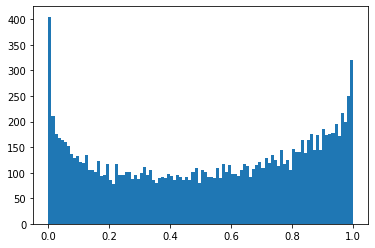

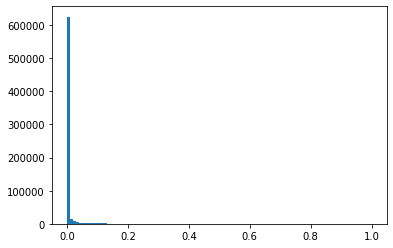

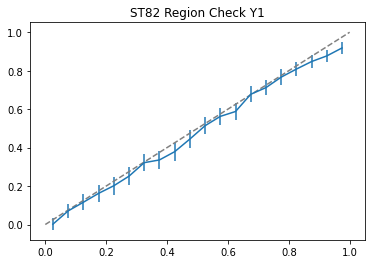

In [21]:
# Figure 3 start: Beverly old:
%matplotlib inline
import matplotlib.pyplot as plt

cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs
# Assigning CMASS probabilities to Gold Y1 in Stripe 82.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

clean_dmass_prob = assignCMASSProb(clean_cmass_data_des, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction
, 
                     mag=mag, err=err, filter=filter )

dmass_st82_real = clean_dmass_prob

dmass_st82_val = assignCMASSProb(gold_st82, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
print('pcenter',pcenter.size)
N, _ = np.histogram(dmass_st82_real['CMASS_PROB'], bins=pbin) # -- true cmass
print('pbin =', pbin)
M, _ = np.histogram(dmass_st82_val['CMASS_PROB'], bins=pbin) # -- dmass

fig, ax = plt.subplots()
ax.hist( dmass_st82_real['CMASS_PROB'], bins= 100)
fig, ax = plt.subplots()
ax.hist( dmass_st82_val['CMASS_PROB'], bins= 100)

#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/M
print('frac = ', frac)
print('frac.size', frac.size)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
print('frac err', fracerr.size)
fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
plt.title('ST82 Region Check Y1')
print(fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo_y1_warner_old.pdf')

In [22]:
warner_pcenter= [] 
warner_frac= []
warner_err= []

for x in range(len(pcenter)):
    print(pcenter[x]*100,frac[x]*100,fracerr[x]*100)
    
    warner_pcenter.append(pcenter[x]*100)
    warner_frac.append(frac[x]*100)
    warner_err.append(fracerr[x]*100)

2.5 0.17081666489207975 2.984077663422269
7.500000000000001 7.063048683160416 3.7582301400141445
12.5 11.573523583036067 4.13802944301184
17.5 16.193961573650505 4.339630366027461
22.5 20.154043645699616 4.607756775840914
27.500000000000004 25.133120340788075 4.602873089491617
32.50000000000001 32.16828478964401 4.485613040162566
37.50000000000001 33.582089552238806 4.714045207910317
42.50000000000001 37.86733837111671 4.70881609348011
47.5 44.44444444444444 4.622501635210242
52.5 51.388888888888886 4.559607525875532
57.50000000000001 56.236786469344615 4.3355498476206
62.500000000000014 58.775981524249424 4.432422071779363
67.5 67.74193548387096 4.279604925109129
72.50000000000001 71.19815668202764 4.022589933545649
77.5 76.6497461928934 4.068942293855797
82.5 80.83700440528634 3.691067352627811
87.50000000000001 84.76890756302521 3.5201667190438144
92.5 87.6937984496124 3.324112476572668
97.50000000000001 91.84 2.9514066805047765


In [23]:
# checking difference between Su and Warner DMASS:

pcenter_diff= su_pcenter-warner_pcenter
frac_diff= su_frac-warner_frac
err_diff= su_err-warner_err

print(su_frac)
print(frac_diff)

fig, ax = plt.subplots()
ax.hist( pcenter_diff, bins= 100)
plt.title('pcenter difference')
fig, ax = plt.subplots()
ax.hist( frac_diff, bins= 100)
plt.title('fraction difference')
fig, ax = plt.subplots()
ax.hist( err_diff, bins= 100)
plt.title('fraction error difference')

TypeError: unsupported operand type(s) for -: 'list' and 'list'

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pcenter 20
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00202386 0.06847721 0.12328767 0.16644562 0.22506862 0.30132053
 0.34206897 0.37213115 0.41081081 0.50833333 0.50229358 0.57943925
 0.62268519 0.67703349 0.74226804 0.76777251 0.81954887 0.83148559
 0.882      0.90877193]
frac.size 20
frac err 20
[0.03869116 0.05322463 0.0571662  0.06311944 0.06375767 0.06311944
 0.06350006 0.06637233 0.06622662 0.06401844 0.06757374 0.06350006
 0.06097108 0.05944383 0.05892557 0.05555556 0.05530013 0.05163978
 0.04761905 0.04393748]


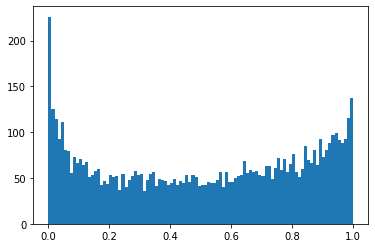

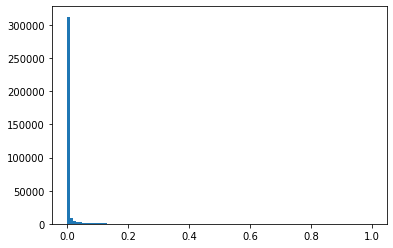

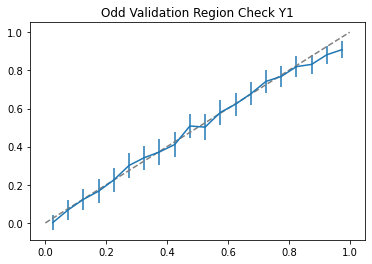

In [26]:
# Figure 3 start: Beverly, New EVEN:
%matplotlib inline
import matplotlib.pyplot as plt

#cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs
# Assigning CMASS probabilities to Gold Y1 in Stripe 82.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

clean_dmass_prob = assignCMASSProb(clean_cmass_data_des_odd, clf_dmass_even, clf_nodmass_even, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

dmass_st82_real = clean_dmass_prob

dmass_st82_val = assignCMASSProb(gold_st82_odd, clf_dmass_even, clf_nodmass_even, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
print('pcenter',pcenter.size)
N, _ = np.histogram(dmass_st82_real['CMASS_PROB'], bins=pbin) # -- true cmass
print('pbin =', pbin)
M, _ = np.histogram(dmass_st82_val['CMASS_PROB'], bins=pbin) # -- dmass

fig, ax = plt.subplots()
ax.hist( dmass_st82_real['CMASS_PROB'], bins= 100)
fig, ax = plt.subplots()
ax.hist( dmass_st82_val['CMASS_PROB'], bins= 100)

#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/M
print('frac = ', frac)
print('frac.size', frac.size)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
print('frac err', fracerr.size)
fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
plt.title('Odd Validation Region Check Y1')
print(fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo_y1_warner_even.pdf')

In [27]:
# save the sample. 
outdir = '../output/test/train_cat/y1/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_st82_val_warner.fits', dmass_st82_val, overwrite=True)

random sampling... 
num of randomly sampled cmass  6325
num of randomly sampled non-cmass  34020
cmass_fraction (cmass/non-cmass):  0.018252545977658307
Using central 100% to set range.
Using central 100% to set range.


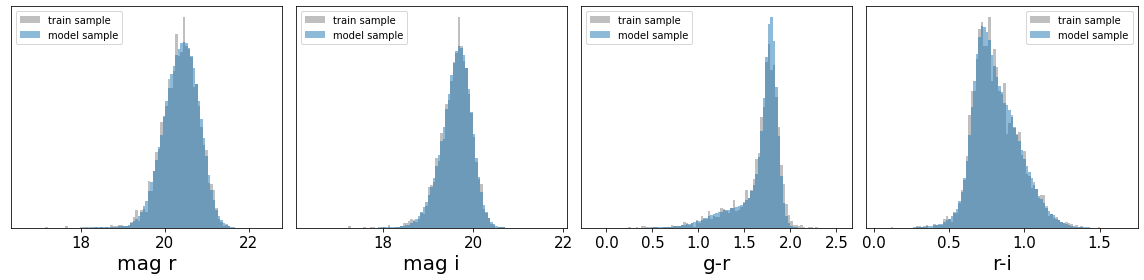

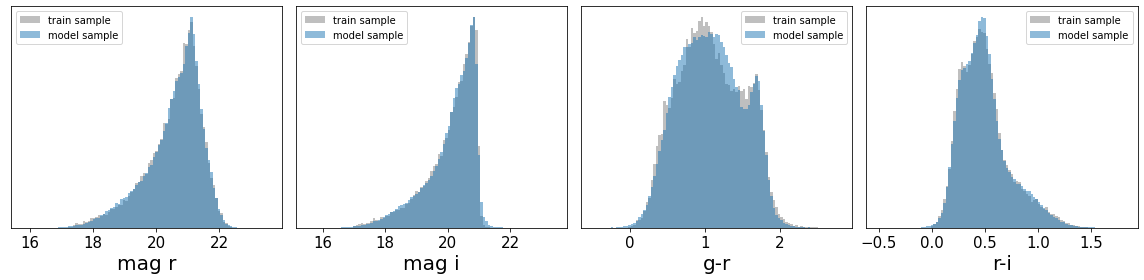

In [18]:
# do ks-test
# make 2D plots: contour plots

n_sample =  int(clean_cmass_data_des_even.size)  # train cmass sample size
n_sample_non = int(nocmass_even.size/10)  # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_cmass_data_des_even.size), size = n_sample)
clean_cmass_data_des_sub = clean_cmass_data_des_even[sampling_ind]
print('num of randomly sampled cmass ', clean_cmass_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(nocmass_even.size), size = n_sample_non )
nocmass_sub = nocmass_even[random_sampling_ind]
print('num of randomly sampled non-cmass ', nocmass_sub.size)

# The fraction of CMASS galaxies in the training region.
# This number is required to put a prior for the Bayesian statistics 
cmass_fraction = clean_cmass_data_des_even.size *1./gold_st82_even.size
print('cmass_fraction (cmass/non-cmass): ', cmass_fraction)
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'cmassfrac', 'w')
f.write('{0:.10f}'.format(cmass_fraction))
f.close()

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_cmass = None    # for cmass
n_no = None       # for non-cmass 

# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )


doVisualization_1d( data=[X_cmass_true, X_sample_dmass_even], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

doVisualization_1d( data=[X_no_true, X_sample_nodmass_even], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

In [36]:
w_odd_pcenter= [] 
w_odd_frac= []
w_odd_err= []

for x in range(len(pcenter)):
    
    w_odd_pcenter.append(pcenter[x]*100)
    w_odd_frac.append(frac[x]*100)
    w_odd_err.append(fracerr[x]*100)

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pcenter 20
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00152014 0.06365129 0.09612519 0.13821138 0.18128655 0.22147651
 0.27657005 0.30222222 0.3216     0.38502674 0.44680851 0.48336595
 0.53862213 0.57366071 0.66371681 0.73043478 0.75       0.83157895
 0.87480438 0.91094891]
frac.size 20
frac err 20
[0.04490133 0.05352877 0.06225728 0.06482037 0.06350006 0.06579517
 0.06608186 0.070014   0.07053456 0.06804138 0.06579517 0.06362848
 0.06225728 0.06237829 0.05773503 0.05455447 0.05205792 0.04593152
 0.04229549 0.04003204]


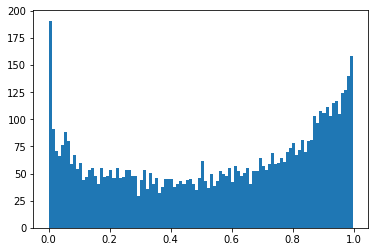

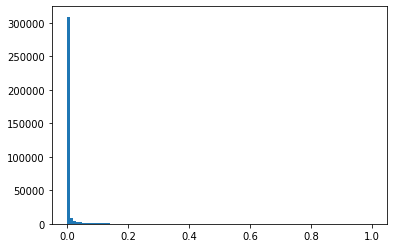

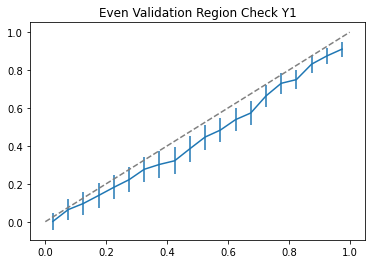

In [37]:
# Figure 3 start: Beverly, New ODD:
%matplotlib inline
import matplotlib.pyplot as plt

#cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs
# Assigning CMASS probabilities to Gold Y1 in Stripe 82.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

clean_dmass_prob = assignCMASSProb(clean_cmass_data_des_even, clf_dmass_odd, clf_nodmass_odd, 
                     cmass_fraction =cmass_fraction_odd
, 
                     mag=mag, err=err, filter=filter )

dmass_st82_real = clean_dmass_prob

dmass_st82_val = assignCMASSProb(gold_st82_even, clf_dmass_odd, clf_nodmass_odd, 
                     cmass_fraction =cmass_fraction_odd
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
print('pcenter',pcenter.size)
N, _ = np.histogram(dmass_st82_real['CMASS_PROB'], bins=pbin) # -- true cmass
print('pbin =', pbin)
M, _ = np.histogram(dmass_st82_val['CMASS_PROB'], bins=pbin) # -- dmass

fig, ax = plt.subplots()
ax.hist( dmass_st82_real['CMASS_PROB'], bins= 100)
fig, ax = plt.subplots()
ax.hist( dmass_st82_val['CMASS_PROB'], bins= 100)

#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/M
print('frac = ', frac)
print('frac.size', frac.size)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
print('frac err', fracerr.size)
fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
plt.title('Even Validation Region Check Y1')
print(fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo_y1_warner_odd.pdf')

In [ ]:
# do ks-test
# make 2D plots: contour plots

n_sample =  int(clean_cmass_data_des_odd.size)  # train cmass sample size
n_sample_non = int(nocmass_odd.size/20)  # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_cmass_data_des_odd.size), size = n_sample)
clean_cmass_data_des_sub = clean_cmass_data_des_odd[sampling_ind]
print('num of randomly sampled cmass ', clean_cmass_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(nocmass_odd.size), size = n_sample_non )
nocmass_sub = nocmass_odd[random_sampling_ind]
print('num of randomly sampled non-cmass ', nocmass_sub.size)

# The fraction of CMASS galaxies in the training region.
# This number is required to put a prior for the Bayesian statistics 
cmass_fraction = clean_cmass_data_des_odd.size *1./gold_st82_odd.size
print('cmass_fraction (cmass/non-cmass): ', cmass_fraction)
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'cmassfrac', 'w')
f.write('{0:.10f}'.format(cmass_fraction))
f.close()

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_cmass = None    # for cmass
n_no = None       # for non-cmass 

# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )


doVisualization_1d( data=[X_cmass_true, X_sample_dmass_odd], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

doVisualization_1d( data=[X_no_true, X_sample_nodmass_odd], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

In [38]:
w_even_pcenter= [] 
w_even_frac= []
w_even_err= []

for x in range(len(pcenter)):
    
    w_even_pcenter.append(pcenter[x]*100)
    w_even_frac.append(frac[x]*100)
    w_even_err.append(fracerr[x]*100)

In [ ]:
#My DMASS colors Y1 distribution for all colors (current y1 version) versus CMASS --- need to alter mixingcolor code

def mixing_color_elg(data, suffix = '', 
    mag = ['MAG_MODEL', 'MAG_DETMODEL'], 
    err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'], 
    filter = ['G', 'R', 'I', 'Z'],
    full=True,
    no_zband = True  ):
    print(mag) 
    magtag = [ m+'_'+f+suffix for m in mag for f in filter ]
    print(magtag)
    errtag = [ e+'_'+f for e in err for f in filter ]
    #del magtag[0], errtag[0]
    if 'Z' in filter: del magtag[3], errtag[3]
    print(magtag)

    X = [ data[mt] for mt in magtag ]
    Xerr = [ data[mt] for mt in errtag ]
    #reddeningtag = 'XCORR_SFD98'

    X = np.vstack(X).T
    Xerr = np.vstack(Xerr).T
    print(X.shape)
    # mixing matrix
    W = np.array([[1, 0, 0, 0, 0, 0, 0],    # g mag
                  [0, 1, 0, 0, 0, 0, 0],    # r mag
                  [0, 0, 1, 0, 0, 0, 0],    # i mag
                  [0, 0, 0, 1, -1, 0, 0],   # g-r
                  #[0, 0, 0, 0, 1, -1, 0],   # r-i
                  #[0, 0, 0, 0, 0, 1, -1],   # i-z
                  [1, 0, 0, 0, 0, 0, -1]])  # r-z
    if full:
        W = np.array([[1, 0, 0, 0, 0, 0, 0],    # g mag
                    [0, 1, 0, 0, 0, 0, 0],    # r mag
                    [0, 0, 1, 0, 0, 0, 0],    # i mag
                    [0, 0, 0, 1, -1, 0, 0],   # g-r
                    [0, 0, 0, 0, 1, -1, 0],   # r-i
                    [0, 0, 0, 0, 0, 1, -1],   # i-z
                    [1, 0, 0, 0, 0, 0, -1]])  # r-z

    #if 'Z' not in filter: W = W[:-1,:-1]
    print(W.shape)
    X = np.dot(X, W.T)

    Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
    Xcov[:, list(range(Xerr.shape[1])), list(range(Xerr.shape[1]))] = Xerr**2
    Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))
    return X, Xcov

In [ ]:
#checking Mixing Colors code:

data = clean_cmass_data_des_sub
mag = ['MAG_MODEL', 'MAG_DETMODEL']
suffix = ''
err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I', 'Z']
full=True
no_zband = False
print(mag)    
magtag = [ m+'_'+f+suffix for m in mag for f in filter ]
print(magtag)

errtag = [ e+'_'+f for e in err for f in filter ]
#del magtag[0], errtag[0]
if 'Z' in filter: del magtag[3], errtag[3]
print(magtag)

X = [ data[mt] for mt in magtag ]
Xerr = [ data[mt] for mt in errtag ]
#reddeningtag = 'XCORR_SFD98'

X = np.vstack(X).T
Xerr = np.vstack(Xerr).T
print(X.shape)
# mixing matrix
W = np.array([[1, 0, 0, 0, 0, 0, 0],    # g mag
    [0, 1, 0, 0, 0, 0, 0],    # r mag
    [0, 0, 1, 0, 0, 0, 0],    # i mag
    [0, 0, 0, 1, -1, 0, 0],   # g-r
    #[0, 0, 0, 0, 1, -1, 0],   # r-i
    #[0, 0, 0, 0, 0, 1, -1],   # i-z
    [1, 0, 0, 0, 0, 0, -1]])  # r-z
if full:
    W = np.array([[1, 0, 0, 0, 0, 0, 0],    # g mag
    [0, 1, 0, 0, 0, 0, 0],    # r mag
    [0, 0, 1, 0, 0, 0, 0],    # i mag
    [0, 0, 0, 1, -1, 0, 0],   # g-r
    [0, 0, 0, 0, 1, -1, 0],   # r-i
    [0, 0, 0, 0, 0, 1, -1],   # i-z
    [1, 0, 0, 0, 0, 0, -1]])  # r-z

#if 'Z' not in filter: W = W[:-1,:-1]
print(W.shape)
X = np.dot(X, W.T)

Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, list(range(Xerr.shape[1])), list(range(Xerr.shape[1]))] = Xerr**2
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))

In [ ]:
n_sample =  int(clean_cmass_data_des.size)  # train cmass sample size
n_sample_non = int(nocmass.size/20)  # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_cmass_data_des.size), size = n_sample)
clean_cmass_data_des_sub = clean_cmass_data_des[sampling_ind]
print('num of randomly sampled cmass ', clean_cmass_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(nocmass.size), size = n_sample_non )
nocmass_sub = nocmass[random_sampling_ind]
print('num of randomly sampled non-cmass ', nocmass_sub.size)

# The fraction of CMASS galaxies in the training region.
# This number is required to put a prior for the Bayesian statistics 
cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
print('cmass_fraction (cmass/non-cmass): ', cmass_fraction)
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'cmassfrac', 'w')
f.write('{0:.10f}'.format(cmass_fraction))
f.close()

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_cmass = None    # for cmass
n_no = None       # for non-cmass 


mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I', 'Z']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color_elg(clean_cmass_data_des_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = False )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color_elg(nocmass_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = False )


doVisualization_1d( data=[X_cmass_true, X_sample_dmass], 
                   labels = ['mag g','mag r', 'mag i', 'g-r', 'r-i', 'i-z', 'r-z'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

doVisualization_1d( data=[X_no_true, X_sample_nodmass], 
                   labels = ['mag g','mag r', 'mag i', 'g-r', 'r-i', 'i-z', 'r-z'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

In [ ]:
# another way: plotting colors

fig, ax = plt.subplots()
ax.hist( clean_cmass_data_des['MAG_MODEL_I'] - clean_cmass_data_des['MAG_MODEL_R'], bins = 100, density=True )
ax.hist( dmass_st82_val['MAG_MODEL_I'] - dmass_st82_val['MAG_MODEL_R'], bins = 100, weight = dmass_st82_val['CMASS_PROB'], density=True)

In [39]:
print(clean_cmass_data_des['MAG_MODEL_I'])

[19.352446 19.637426 20.191978 ... 19.70943  20.028873 19.41806 ]


In [50]:
# comparing values:
#Su's odd versus my odd and even:
diff__pcenter_odd = []
for x in range(len(su_frac)):
    diff = su_pcenter[x]-w_odd_pcenter[x]
    diff__pcenter_odd.append(diff)
print(diff__pcenter_odd)

diff_frac_odd = []
for x in range(len(su_frac)):
    diff = su_frac[x]-w_odd_frac[x]
    diff_frac_odd.append(diff)
print(diff_frac_odd) 

diff_err_odd = []
for x in range(len(su_frac)):
    diff = su_err[x]-w_odd_err[x]
    diff_err_odd.append(diff)
print(diff_err_odd) 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.003353941645704017, 0.007297777293183039, 2.4879476584022058, 2.140879079656843, 2.5744876463867463, 1.2189989443480798, 6.38873839642503, 4.883553606454868, 2.5106467737193086, 9.208061051958133, 3.4696428571428655, 3.1581964628658312, 5.979864296196318, 6.488346090995101, 0.577956989247312, 6.606015635921736, -0.04118080540985147, 2.0309573104604084, 1.4743656951142867, 1.132083724139946]
[-0.0404224496530734, -0.17480091674154252, -0.7470725614953047, -0.26729491281812123, -0.4354963865392971, 0.1584555193715298, -0.3509608093297425, 0.11993089398292689, 0.10134502368053955, -0.13621482980834276, 0.127787566958526, 0.07482688758573186, 0.05714497383766659, 0.18555328883002797, 0.6703865716020108, -0.06129066388354776, 0.5132703493297717, 0.1695595507558023, 0.39673220376907814, -0.349573276256657]


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-0.74707256, -0.73289797, -0.71872338, -0.70454879, -0.6903742 ,
        -0.6761996 , -0.66202501, -0.64785042, -0.63367583, -0.61950124,
        -0.60532665, -0.59115206, -0.57697747, -0.56280287, -0.54862828,
        -0.53445369, -0.5202791 , -0.50610451, -0.49192992, -0.47775533,
        -0.46358073, -0.44940614, -0.43523155, -0.42105696, -0.40688237,
        -0.39270778, -0.37853319, -0.3643586 , -0.350184  , -0.33600941,
        -0.32183482, -0.30766023, -0.29348564, -0.27931105, -0.26513646,
        -0.25096186, -0.23678727, -0.22

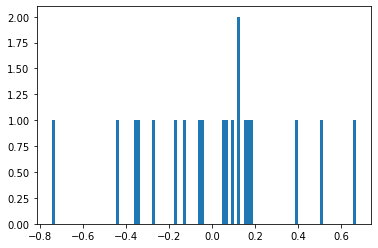

In [51]:
fig,ax=plt.subplots()
ax.hist(diff_err_odd, bins=100)